# 1. Import essential libraries:

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import librosa
import matplotlib.pyplot as plt
import tensorflow_io as tfio
import IPython.display as ipd

2024-06-01 17:43:37.683245: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-01 17:43:42.918015: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 2. Define path to example file:

In [2]:
PL_LANG_FILE = os.path.join('common_voice_pl_20547814.mp3')
PL_LANG_FILE

'common_voice_pl_20547814.mp3'

# 3. Load encoded audio file:

In [3]:
file_content = tfio.audio.AudioIOTensor(filename=PL_LANG_FILE)
file_content

2024-06-01 17:43:48.274138: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
2024-06-01 17:43:48.469587: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-01 17:43:49.782908: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


<AudioIOTensor: shape=[240768      1], dtype=<dtype: 'float32'>, rate=48000>

### 3.1 Convert to tensor:

In [4]:
import tensorflow_io as tfio
wav = tfio.audio.AudioIOTensor(filename=PL_LANG_FILE).to_tensor()

### 3.2 Print audio vector shape:

In [5]:
print(f'wav shape: {wav.shape}')
wav

wav shape: (240768, 1)


<tf.Tensor: shape=(240768, 1), dtype=float32, numpy=
array([[0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       ...,
       [1.1837233e-09],
       [1.4704506e-08],
       [3.3379088e-08]], dtype=float32)>

# 4. Delete dimensions with shape 1 (in this case the last axis):

In [6]:
wav = tf.squeeze(wav, axis=-1)

In [7]:
print(f'new wav shape: {wav.shape}')

new wav shape: (240768,)


# 5. Resample audio file (in this case to 16 000 kHz):

In [8]:
curr_sr = tf.cast(48_000, tf.int64)
wav = tfio.audio.resample(wav, rate_in=curr_sr, rate_out=16_000)

### 5.1 Resampled audio:

In [9]:
wav.shape

TensorShape([80256])

# 6. Plot audio:

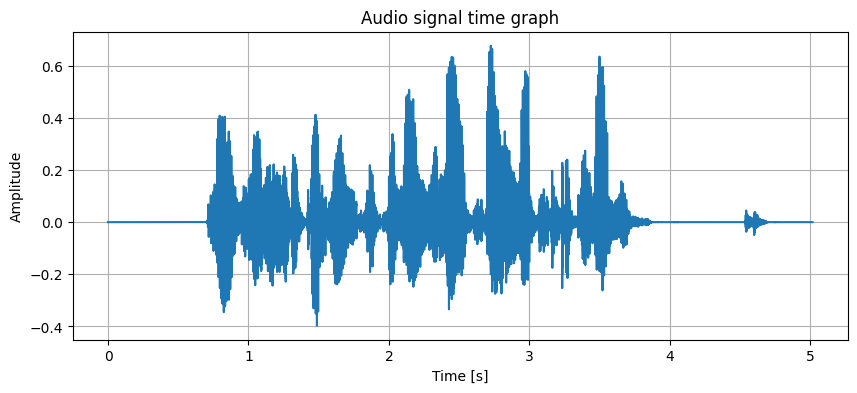

In [10]:
time_axis = np.linspace(0, len(wav) / 16_000, num=len(wav))

plt.figure(figsize=(10, 4))
plt.plot(time_axis, wav)
plt.title('Audio signal time graph')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# 7. Display audio:

In [11]:
ipd.Audio(PL_LANG_FILE)

# 8 Audio transformations:

### 8.1 Define functions to transform audio:

In [12]:
def increase_amplitude(wav, min_increase=2.0, max_increase=5.0):
    increased_wav = wav * random.uniform(min_increase, max_increase)
    return tf.convert_to_tensor(increased_wav, dtype=tf.float32)

''' Normalize from -1 to 1 '''
def normalize_audio(wav):
    max_amplitude = tf.reduce_max(tf.abs(wav))
    normalized_wav = wav / max_amplitude  
    return normalized_wav

def add_noise(wav, noise_level=0.1):
    noise = tf.random.normal(tf.shape(wav), mean=0.0, stddev=noise_level)
    return wav + noise

def time_masking(wav, max_mask_length=10000):
    if wav is None or tf.rank(wav) != 1:
        return wav

    if tf.shape(wav)[0] <= max_mask_length:
        return wav
    
    ''' Draw mask length '''
    mask_length = tf.random.uniform([], maxval=max_mask_length, dtype=tf.int32)
    
    ''' Check property of mask '''
    mask_start_max = tf.shape(wav)[0] - mask_length
    mask_start = tf.random.uniform([], maxval=mask_start_max, dtype=tf.int32)
    
    mask = tf.concat([
        tf.ones([mask_start]),
        tf.zeros([mask_length]),
        tf.ones([tf.shape(wav)[0] - mask_start - mask_length])
    ], axis=0)
    
    return wav * mask

def change_pitch(wav, sample_rate=16_000, pitch_shift=2):
    if type(wav) is not np.ndarray:
        wav = wav.numpy() 
    pitched_wav = librosa.effects.pitch_shift(wav, sr=sample_rate, n_steps=pitch_shift)
    return tf.convert_to_tensor(pitched_wav, dtype=tf.float32)

def speed_up_audio(wav, speed_factor=2):
    if type(wav) is not np.ndarray:
        wav = wav.numpy() 
    stretched_wav = librosa.effects.time_stretch(wav, rate=speed_factor)
    return stretched_wav

def slow_down_audio(wav, speed_factor=0.5):
    if type(wav) is not np.ndarray:
        wav = wav.numpy() 
    slowed_wav_np = librosa.effects.time_stretch(wav, rate=speed_factor)
    return tf.convert_to_tensor(slowed_wav_np, dtype=tf.float32)

### 8.2 Change amplitude:

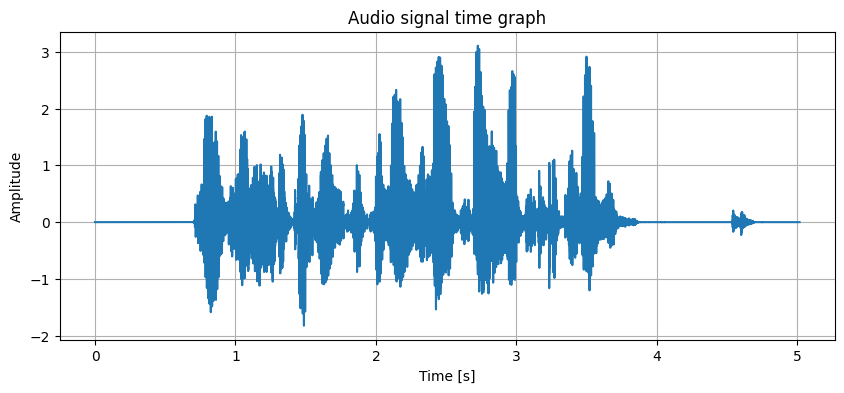

In [13]:
wav_amp = increase_amplitude(wav)

time_axis = np.linspace(0, len(wav_amp) / 16_000, num=len(wav_amp))

plt.figure(figsize=(10, 4))
plt.plot(time_axis, wav_amp)
plt.title('Audio signal time graph')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

### 8.3 Normalize audio:

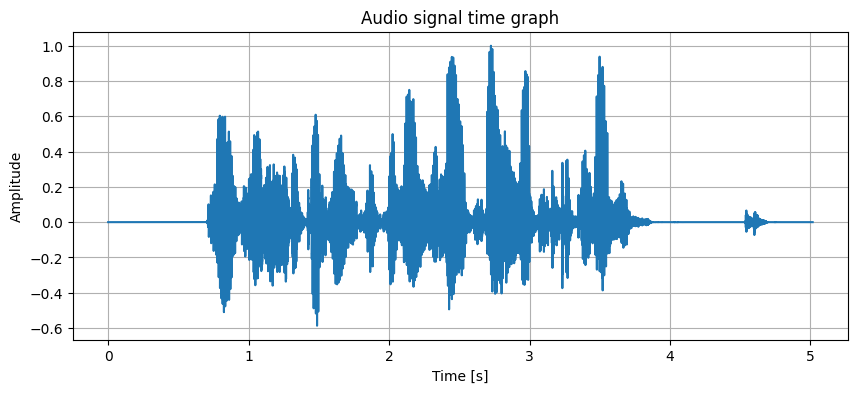

In [14]:
wav_norm = normalize_audio(wav)

time_axis = np.linspace(0, len(wav_norm) / 16_000, num=len(wav_norm))

plt.figure(figsize=(10, 4))
plt.plot(time_axis, wav_norm)
plt.title('Audio signal time graph')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

### 8.4 Add noise:

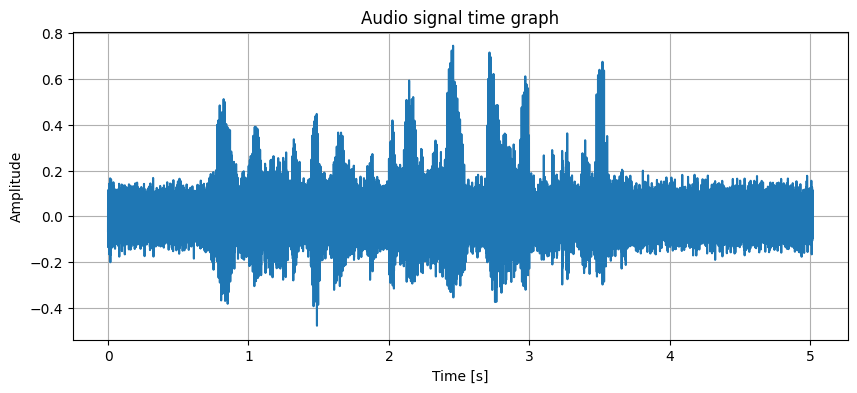

In [15]:
wav_noise = add_noise(wav, noise_level=0.05)
time_axis = np.linspace(0, len(wav_noise) / 16_000, num=len(wav_noise))

plt.figure(figsize=(10, 4))
plt.plot(time_axis, wav_noise)
plt.title('Audio signal time graph')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

### 8.5 Time masking:

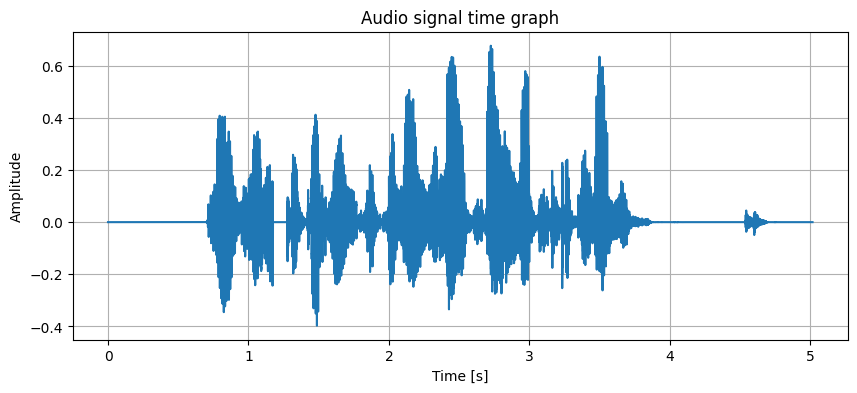

In [16]:
wav_time_mask = time_masking(wav, max_mask_length=7000)
time_axis = np.linspace(0, len(wav_time_mask) / 16_000, num=len(wav_time_mask))

plt.figure(figsize=(10, 4))
plt.plot(time_axis, wav_time_mask)
plt.title('Audio signal time graph')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

### 8.6 Change pitch:

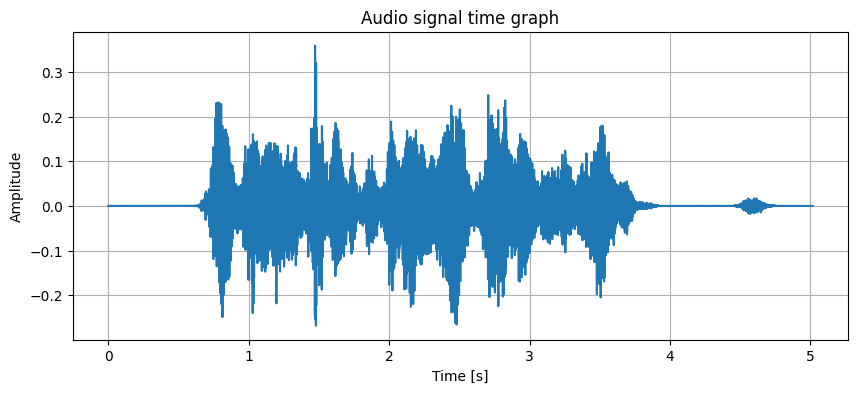

In [17]:
wav_pitch = change_pitch(wav) 
time_axis = np.linspace(0, len(wav_pitch) / 16_000, num=len(wav_pitch))

plt.figure(figsize=(10, 4))
plt.plot(time_axis, wav_pitch)
plt.title('Audio signal time graph')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

### 8.7 Speed up audio:

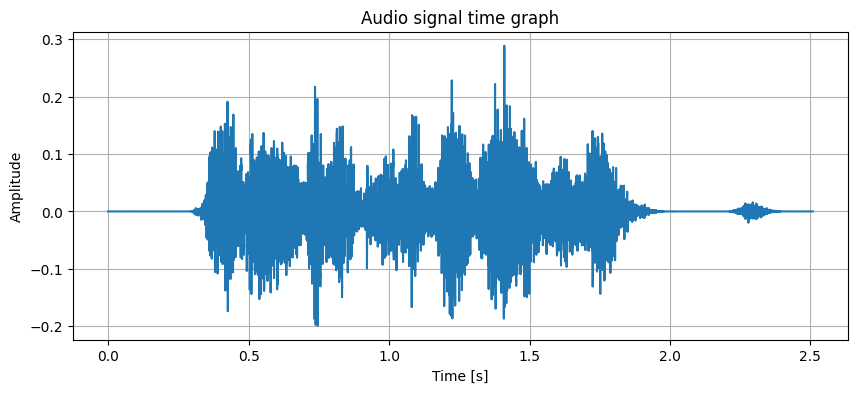

In [18]:
wav_speed_up = speed_up_audio(wav)
time_axis = np.linspace(0, len(wav_speed_up) / 16_000, num=len(wav_speed_up))

plt.figure(figsize=(10, 4))
plt.plot(time_axis, wav_speed_up)
plt.title('Audio signal time graph')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

### 8.8 Slow down audio:

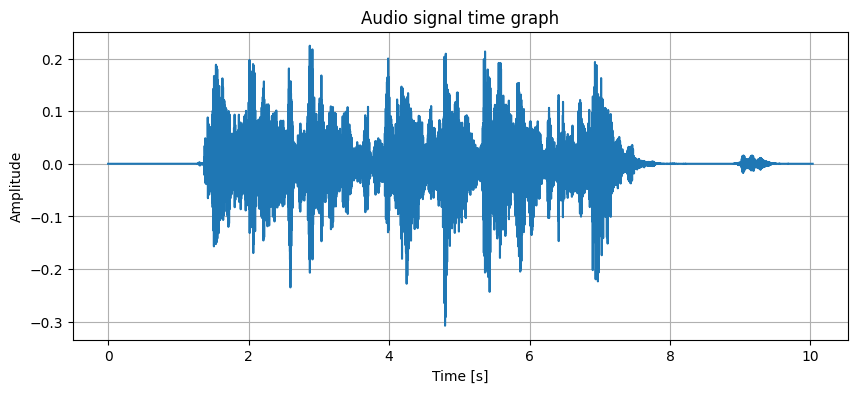

In [19]:
wav_slow_down= slow_down_audio(wav)
time_axis = np.linspace(0, len(wav_slow_down) / 16_000, num=len(wav_slow_down))

plt.figure(figsize=(10, 4))
plt.plot(time_axis, wav_slow_down)
plt.title('Audio signal time graph')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# 9 Functions to align audio:

In [20]:
min_clip_dur = 4000
def add_zeros(audio: tf.Tensor, sample_rate) -> tf.Tensor:
    time_probes = tf.cast(tf.shape(audio)[0], dtype=tf.int32)
    print(time_probes)
    min_clip_duration_probes = tf.cast((min_clip_dur / 1000) * sample_rate, dtype=tf.int32)
    print(min_clip_duration_probes)
    missing_probes_one_side = tf.cast((min_clip_duration_probes - time_probes) / 2, dtype=tf.int32)
    print(missing_probes_one_side)
    padded_tensor = tf.pad(audio, [[missing_probes_one_side, missing_probes_one_side]])
    print(padded_tensor)
    return padded_tensor

def cut_audio(audio: tf.Tensor, sample_rate: int) -> tf.Tensor:
    time_probes = tf.cast(tf.shape(audio)[0], dtype=tf.int32)
    min_clip_duration_probes = tf.cast((min_clip_dur / 1000) * sample_rate, dtype=tf.int32)
    overlap = tf.cast((time_probes - min_clip_duration_probes) / 2, dtype=tf.int32)
    cut_clip = audio[overlap:(time_probes - overlap)]
    return cut_clip


def align_probes(audio: tf.Tensor, sample_rate: int) -> tf.Tensor:
    expected_probes = tf.cast((min_clip_dur / 1000) * 16_000, dtype=tf.int32)
    current_probes = tf.cast(tf.shape(audio)[0], dtype=tf.int32)
    if expected_probes > current_probes:
        print("ADD ZEROS")
        audio = add_zeros(audio, sample_rate)
    elif expected_probes < current_probes:
        print("CUT AUDIO")
        audio = cut_audio(audio, sample_rate)
    return audio

### 9.1 Align audio:

In [21]:
wav_cut = align_probes(wav, 16_000)
wav_cut.shape

CUT AUDIO


TensorShape([64000])

### 9.2 Plot aligned audio:

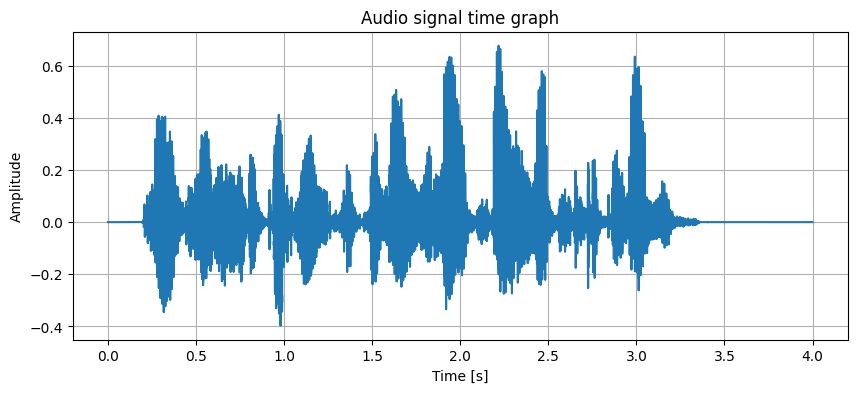

In [22]:
time_axis = np.linspace(0, len(wav_cut) / 16_000, num=len(wav_cut))

plt.figure(figsize=(10, 4))
plt.plot(time_axis, wav_cut)
plt.title('Audio signal time graph')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# 10 Spectrogram:

### 10.1 Linear scale spectrogram:

(500, 513)


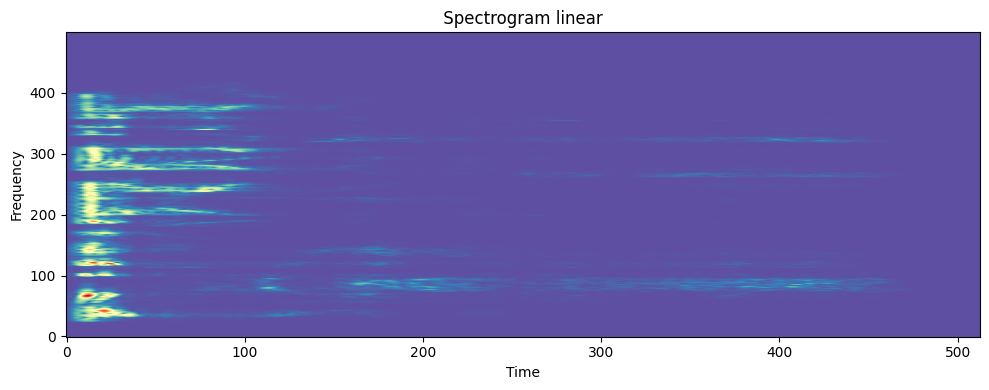

In [23]:
spectrogram = tfio.audio.spectrogram(
    wav_cut, nfft=1024, window=256, stride=128)

print(spectrogram.shape)

plt.figure(figsize=(10, 4))
plt.imshow(spectrogram.numpy(), aspect='auto', origin='lower', cmap='Spectral_r')
plt.title(' Spectrogram linear ')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


### 10.2 Mel scale spectrogram:

(500, 512)


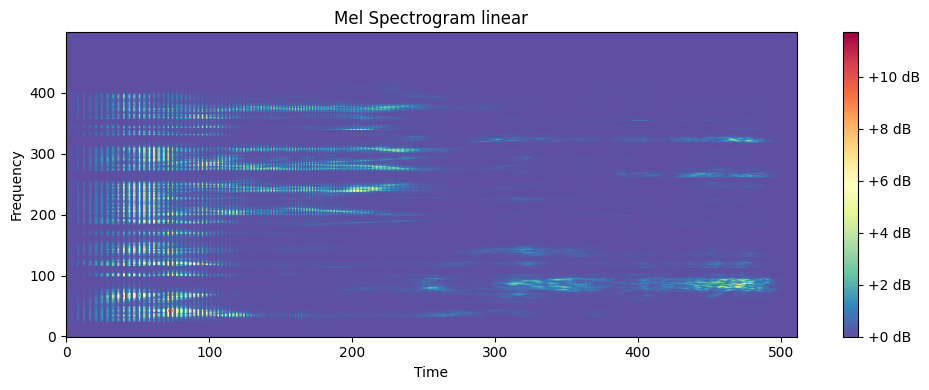

In [24]:
mel_spectrogram = tfio.audio.melscale(
    spectrogram, rate=16000, mels=512, fmin=0, fmax=8000)

print(mel_spectrogram.shape)
plt.figure(figsize=(10, 4))

plt.imshow(mel_spectrogram.numpy(), aspect='auto', origin='lower', cmap='Spectral_r')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram linear')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### 10.3 db mel scale spectrogram:

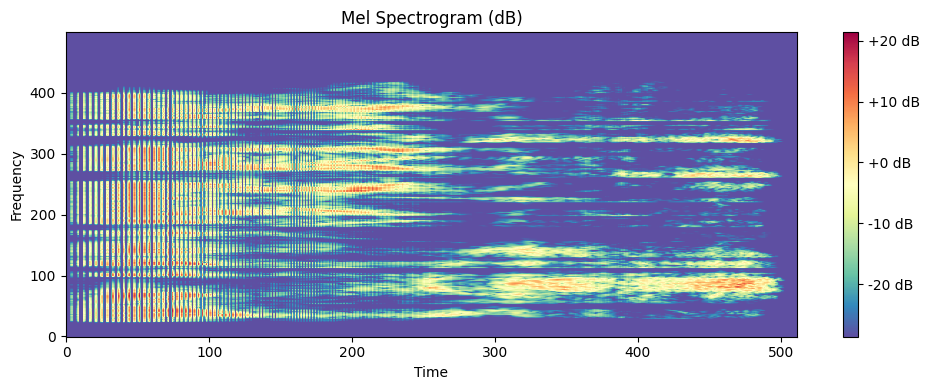

21.374681
-28.625319


In [25]:
dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=50)

plt.figure(figsize=(10, 4))
plt.imshow(dbscale_mel_spectrogram.numpy(), aspect='auto', origin='lower', cmap='Spectral_r')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram (dB)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
print(dbscale_mel_spectrogram.numpy().max())
print(dbscale_mel_spectrogram.numpy().min())